--- Starting Data Loading and Preprocessing ---
Encoded Alloy Types: ['Al Mg Bi', 'Al Mg Sr', 'Al Mg Zn', 'Pure Mg']
--- Data Preprocessing Complete ---
Shape of processed data: (240061, 4)
   Timestamp       COF Alloy_Type  Alloy_Type_Encoded
0      0.023  0.500118    Pure Mg                   3
1      0.033  0.500118    Pure Mg                   3
2      0.043  0.500063    Pure Mg                   3
3      0.053  0.499967    Pure Mg                   3
4      0.063  0.499852    Pure Mg                   3

Training data shape: (192048, 2), Test data shape: (48013, 2)

--- Training and Evaluating Machine Learning Models ---
Training Random Forest Regressor...
Random Forest Regressor - R2: 0.9990, MAE: 0.0024, MSE: 0.0000, RMSE: 0.0034
Training Support Vector Regressor...
Support Vector Regressor - R2: 0.3151, MAE: 0.0711, MSE: 0.0078, RMSE: 0.0886
Training Gradient Boosting Regressor...
Gradient Boosting Regressor - R2: 0.3481, MAE: 0.0693, MSE: 0.0075, RMSE: 0.0864
Training Linear R

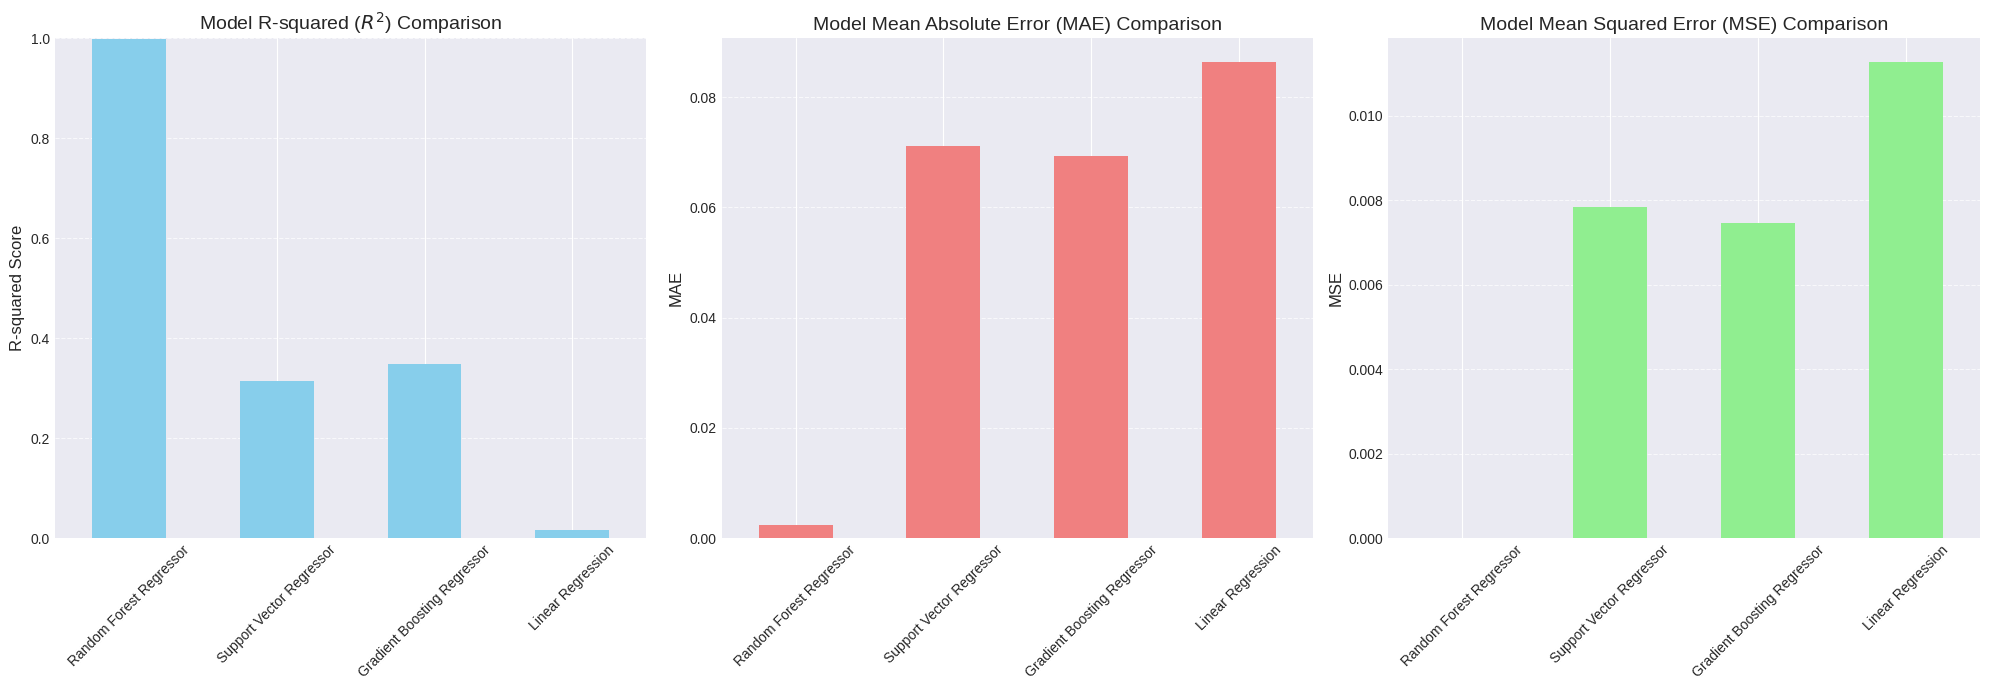


--- Plotting Actual vs. Predicted COF for the best model: Random Forest Regressor ---


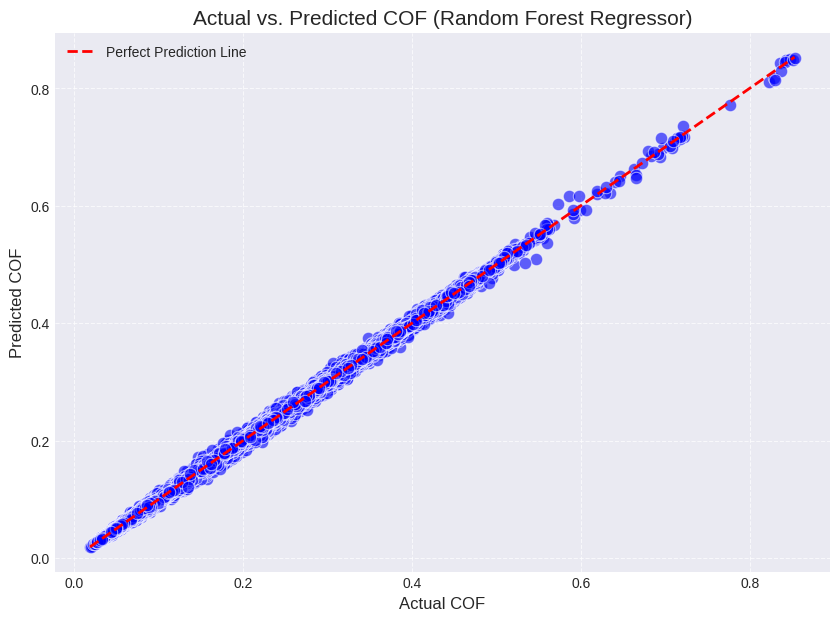


--- Feature Importance for Random Forest Regressor ---
              Feature  Importance
0           Timestamp    0.793379
1  Alloy_Type_Encoded    0.206621


/tmp/ipython-input-4261825566.py:198: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


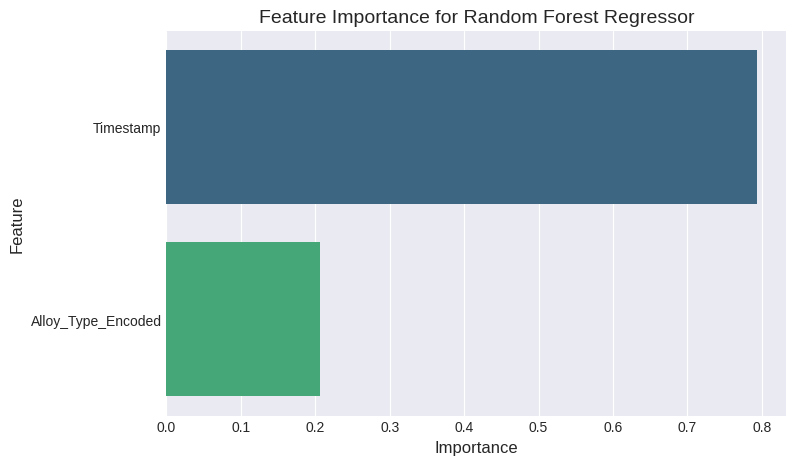


--- Script Finished ---


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --- 1. Load and Preprocess the Dataset ---
print("--- Starting Data Loading and Preprocessing ---")

# Load the raw CSV file without assuming a header, as it has a unique structure
df_raw = pd.read_csv('Friction_File.csv', header=None)

# Extract alloy names from the first row
# The alloy names are in columns 0, 2, 4, 6 of the first row
alloy_names_row = df_raw.iloc[0]

# Create a list to store processed dataframes for each alloy type
all_data = []

# Iterate through the columns, taking 2 columns at a time (Timestamp, COF)
# The data for each alloy starts from the 3rd row (index 2)
# The columns are structured as [Alloy1_Timestamp, Alloy1_COF, Alloy2_Timestamp, Alloy2_COF, ...]
for i in range(0, len(df_raw.columns), 2):
    # Get the alloy name from the first row, handling potential NaNs if the first row isn't perfectly aligned
    alloy_name = alloy_names_row.iloc[i]
    if pd.isna(alloy_name):
        # If the current cell in the first row is NaN, try to find the previous non-NaN alloy name
        # This handles cases where the alloy name might only be above the first column of a pair
        for j in range(i - 1, -1, -1):
            if not pd.isna(alloy_names_row.iloc[j]):
                alloy_name = alloy_names_row.iloc[j]
                break

    # Extract the Timestamp and COF columns for the current alloy
    # We take all rows starting from index 2 (actual data) and the current pair of columns
    temp_df = df_raw.iloc[2:, [i, i+1]].copy()

    # Rename columns for clarity and consistency
    temp_df.columns = ['Timestamp', 'COF']

    # Add the alloy type column
    temp_df['Alloy_Type'] = str(alloy_name).strip() # Ensure it's a string and remove whitespace

    all_data.append(temp_df)

# Concatenate all individual alloy dataframes into a single, long format dataframe
df = pd.concat(all_data, ignore_index=True)

# Convert 'Timestamp' and 'COF' columns to numeric, coercing any errors to NaN
df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
df['COF'] = pd.to_numeric(df['COF'], errors='coerce')

# Drop any rows that contain NaN values (e.g., from header parsing or non-numeric data)
df.dropna(inplace=True)

# Encode 'Alloy_Type' into numerical format using LabelEncoder
# This is necessary as ML models require numerical inputs
le = LabelEncoder()
df['Alloy_Type_Encoded'] = le.fit_transform(df['Alloy_Type'])
print(f"Encoded Alloy Types: {list(le.classes_)}")

print("--- Data Preprocessing Complete ---")
print(f"Shape of processed data: {df.shape}")
print(df.head())

# --- 2. Define Features and Target, Split Data ---
# Features (X): 'Timestamp' and the numerical 'Alloy_Type_Encoded'
X = df[['Timestamp', 'Alloy_Type_Encoded']]
# Target (y): 'COF' (Coefficient of Friction)
y = df['COF']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining data shape: {X_train.shape}, Test data shape: {X_test.shape}")

# Scale features for models sensitive to feature scaling (e.g., SVR)
# StandardScaler transforms data to have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 3. Initialize and Train Machine Learning Models ---
print("\n--- Training and Evaluating Machine Learning Models ---")

# Define the models to be compared
models = {
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1), # RBF kernel, common hyperparameters
    "Gradient Boosting Regressor": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "Linear Regression": LinearRegression()
}

# Dictionary to store performance results for each model
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    if name == "Support Vector Regressor":
        # SVR performs better with scaled data
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        # Other models can use unscaled data directly
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # --- 4. Evaluate Model Performance ---
    r2 = r2_score(y_test, y_pred) # R-squared (coefficient of determination)
    mae = mean_absolute_error(y_test, y_pred) # Mean Absolute Error
    mse = mean_squared_error(y_test, y_pred) # Mean Squared Error
    rmse = np.sqrt(mse) # Root Mean Squared Error

    results[name] = {"R2": r2, "MAE": mae, "MSE": mse, "RMSE": rmse}
    print(f"{name} - R2: {r2:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")

# Convert results to a DataFrame for easy comparison and plotting
results_df = pd.DataFrame(results).T
print("\n--- Model Comparison Results ---")
print(results_df)

# --- 5. Visualize Comparative Results ---
print("\n--- Generating Performance Comparison Plots ---")

plt.style.use('seaborn-v0_8-darkgrid') # Set a nice plot style

# Create subplots for R-squared, MAE, and MSE
fig, axes = plt.subplots(1, 3, figsize=(20, 7)) # One row, three columns for metrics

# Plot R-squared
results_df['R2'].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Model R-squared ($R^2$) Comparison', fontsize=14)
axes[0].set_ylabel('R-squared Score', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].set_ylim(0, 1) # R-squared typically ranges from 0 to 1

# Plot Mean Absolute Error (MAE)
results_df['MAE'].plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Model Mean Absolute Error (MAE) Comparison', fontsize=14)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Mean Squared Error (MSE)
results_df['MSE'].plot(kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title('Model Mean Squared Error (MSE) Comparison', fontsize=14)
axes[2].set_ylabel('MSE', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.savefig(f"{plt.gca().get_title().replace(' ', '_') if plt.gca().get_title() else 'figure'}.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# --- Optional: Plot Actual vs. Predicted for the Best Performing Model ---
# Identify the best model based on R-squared score (higher is better)
best_model_name = results_df['R2'].idxmax()
best_model = models[best_model_name]

print(f"\n--- Plotting Actual vs. Predicted COF for the best model: {best_model_name} ---")

# Get predictions for the best model on the test set
if best_model_name == "Support Vector Regressor":
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.6, color='blue', edgecolor='w', s=80)
# Add a diagonal line (y=x) for perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction Line')
plt.xlabel("Actual COF", fontsize=12)
plt.ylabel("Predicted COF", fontsize=12)
plt.title(f"Actual vs. Predicted COF ({best_model_name})", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# --- Optional: Feature Importance for Tree-based Models ---
# Feature importance is a useful metric for understanding which features contribute most to the prediction
if best_model_name in ["Random Forest Regressor", "Gradient Boosting Regressor"]:
    print(f"\n--- Feature Importance for {best_model_name} ---")
    feature_importances = best_model.feature_importances_
    features = X.columns # Get the names of the features

    # Create a DataFrame for better visualization of importances
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print(importance_df)

    plt.figure(figsize=(8, 5))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title(f'Feature Importance for {best_model_name}', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.show()

print("\n--- Script Finished ---")

In [5]:
for alloy_code in X_test['Alloy_Type_Encoded'].unique():
    alloy_name = alloy_labels[alloy_code]
    idx = X_test['Alloy_Type_Encoded'] == alloy_code
    X_alloy = X_test[idx]
    y_alloy = y_test[idx]

    if best_model_name == "Support Vector Regressor":
        X_input = scaler.transform(X_alloy)
        y_pred = best_model.predict(X_input)
    else:
        y_pred = best_model.predict(X_alloy)

    plt.figure(figsize=(7, 5))
    sns.scatterplot(x=y_alloy, y=y_pred, color='b', alpha=0.7, edgecolor='k')
    plt.plot([y_alloy.min(), y_alloy.max()], [y_alloy.min(), y_alloy.max()], 'r--', lw=1.5, label='Perfect Prediction')
    plt.xlabel("Actual COF")
    plt.ylabel("Predicted COF")
    plt.title(f"Actual vs. Predicted COF for {alloy_name}")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    # Save as high-quality PDF
    plt.savefig(f"Actual_vs_Predicted_COF_{alloy_name}.pdf", format='pdf', dpi=300)
    plt.close()  # Close the figure to free memory

